In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
from energies import Energies
from models import ConstrainedNet

## Load Image

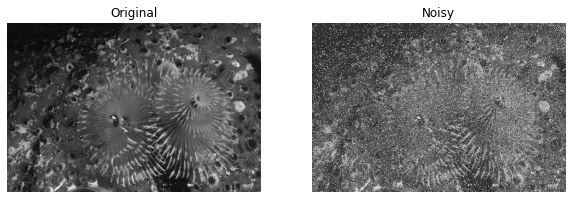

In [14]:
clear, noisy = utils.load_image(11, noiseamount=0.1) # specify amount of noise and image

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(clear[0],cmap="gray")
ax1.set_title("Original")
ax1.axis("off")
ax2.imshow(noisy[0],cmap="gray")
ax2.set_title("Noisy")
ax2.axis("off")
plt.show()

## Prepare

In [15]:
device="cuda"
# prepare images
Y = clear[None].float()
f = noisy[None].float()
f = f.to(device)
Y = Y.to(device)

file = "./example/net_denoise2d_0_0.05_30.0_1_0.1.pt"
filevars = file.split('/')[-1]
vars = filevars.split('_')

# setting
l2 = 0.0#float(vars[2])
alpha = 1.0#float(vars[5])
mu = 0.1#float(vars[6].split('.pt')[0])
assert (l2 == 0) or (l2 == 1)
print(l2,alpha,mu)

# Load Network
network_onenorm = torch.load(file)
net1n = ConstrainedNet(in_chn = 3, out_chn = 1, zeta1 = network_onenorm.zeta1, zeta2 = network_onenorm.zeta2, \
                    features = 64, num_layers = 20, constrained=network_onenorm.constrained)
net1n.load_state_dict(network_onenorm.state_dict())
net1n.eval()
net1n.to(device)

# load l1 norm energy and gradient function
gradient_l1 = Energies.gradient_l1_alpha(alpha, mu)
energy_l1 = Energies.energy_l1_alpha(alpha, mu)
# load l2 norm energy and gradient function
if float(vars[2]) > 0.5:
    gradient_l1 = Energies.gradient_l2_alpha(alpha)
    energy_l1 = Energies.energy_l2_alpha(alpha)
# noise measurement
noise_amount = lambda x: torch.abs(torch.norm(f-x, 1)-torch.norm(f-Y, 1))
noise_amount_l2 = lambda x: torch.abs(torch.norm(f-x)-torch.norm(f-Y))

0.0 1.0 0.1


## Optimize

100%|██████████| 20/20 [00:00<00:00, 60.15it/s]


zeta1: 0.050, zeta2: 30.0 ---- Best Iterationpoint: 2 ----> PSNR: 36.517247


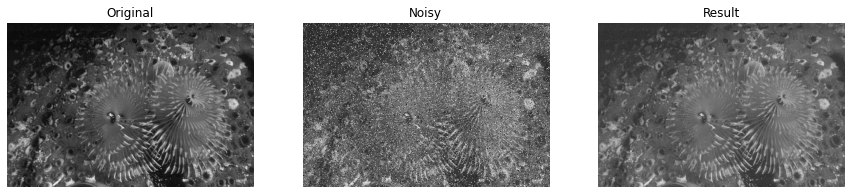

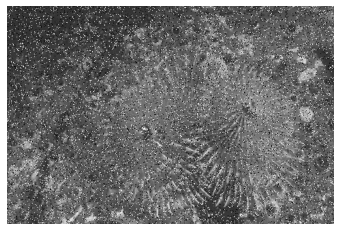

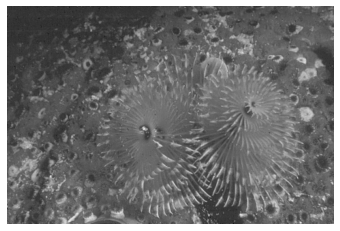

In [16]:
def get_stepsize(l2loss=False, mu=1, alpha=1, net=None):
    if l2loss:
        L = alpha
    else:
        L=1/mu
    return net.zeta1 / ((net.zeta2**2)*L)

# stepsize and startingpoint
X = f[0].mean(dim=(1,2)).view(1,1).expand(f.shape[-2], f.shape[-1]).clone()[None,None].to(device)
tau_d = get_stepsize(l2,mu,alpha,net1n)

psnrs=[]
ssims=[]
results=[]
n_dist=[]
n_dist_l2=[]
energies=[]

# save values from the beginning
psnr_val, ssim_val = utils.metrics_psnr_ssim(Y, X)
psnrs.append(psnr_val)
results.append(X.cpu())
ssims.append(ssim_val)

pbar = tqdm(range(20))
for i in pbar:
    # update learning rate
    tau_v = 1/(i+1)
    tau = np.maximum(tau_v,tau_d)
    # direction
    d_dir = -gradient_l1(X,f)
    with torch.no_grad():
        d_dir = net1n(X, -d_dir, f)
    # step
    X = X + tau * d_dir
    # save
    n_dist.append(noise_amount(X).cpu())
    n_dist_l2.append(noise_amount_l2(X).cpu())
    psnr_val, ssim_val = utils.metrics_psnr_ssim(Y, X)
    psnrs.append(psnr_val)
    ssims.append(ssim_val)
    results.append(X.cpu())
    energies.append(energy_l1(X,f).cpu())

max_psnr = np.argmax(psnrs)
low_dist_psnr = np.argmin(n_dist)
low_dist_psnr_l2 = np.argmin(n_dist_l2)
point_text = "zeta1: %2.3f, zeta2: %2.1f ---- Best Iterationpoint: %d ----> PSNR: %f"%(net1n.zeta1,net1n.zeta2,max_psnr,psnrs[max_psnr])
print(point_text)

# plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(clear[0],cmap="gray")
ax1.set_title("Original")
ax1.axis("off")
ax2.imshow(noisy[0],cmap="gray")
ax2.set_title("Noisy")
ax2.axis("off")
ax3.imshow(results[max_psnr][0,0].cpu(),vmin=0,vmax=1,cmap="gray")
ax3.set_title("Result")
ax3.axis("off")
plt.show()